<a href="https://colab.research.google.com/github/pragneshrana/WorkSample/blob/main/AutomationControl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R&D @ [Nishtha Automation](http://www.nishthaindia.com/)

- Nishtha has developed a machine designed for processing raw diamonds. This machine is equipped to perform four primary processes: Table Sawing, Crowning, Bruiting (Girdle Outline), Cone Blocking, and additional facet processes.

- The primary objective of the project was to create an analytical/machine learning model capable of predicting potential diamond failures based on specific parameters.

- Another key goal was to implement a predictive model to control machine vibrations, with the aim of preventing failures by anticipating and mitigating excessive vibration levels.

#### Sample of Diamonds parameter and machining process data

In [142]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
np.random.seed(126)

Goals:
- Predict vibration value to minimize manufaturing risk (predict vibration)
- Predict with processing prediction failure will happen or not (to avoid failure)

### Manufacturing

- We can control parameters like vibration and motorspeed
- Vibration is main culprit for failure.
-  ADXL345, a tri-axial accelerometer from Analog Devices. It's widely used in various applications, including vibration monitoring. It's MEMS (Micro-Electro-Mechanical Systems) accelerometer. Accelerometers measure acceleration in units of g-force (gravity force), where 1 g is equal to the acceleration due to gravity.
- For reference, low vibration levels might be in the range of 0.01 to 0.1 g, moderate levels might be around 0.1 to 1 g, and high levels could be above 1 g.

In [143]:
class DummyDataGenerator:
    def __init__(self, num_samples_diamond=100):
        self.num_samples_diamond = num_samples_diamond
        self.diamond_data = self.generate_dummy_diamond_data()

    def generate_dummy_diamond_data(self):
        # Carat Weight (random values between 0.2 and 3.0)
        carat_weight = np.random.uniform(0.2, 3.0, self.num_samples_diamond)

        # Cut (random choice from common cut grades)
        cut_grades = ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor']
        cut = np.random.choice(cut_grades, self.num_samples_diamond)

        # Color (random choice from common color grades)
        color_grades = ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
        color = np.random.choice(color_grades, self.num_samples_diamond)

        # Clarity (random choice from common clarity grades)
        clarity_grades = ['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3']
        clarity = np.random.choice(clarity_grades, self.num_samples_diamond)

        # Shape (random choice from common diamond shapes)
        diamond_shapes = ['Round', 'Princess', 'Emerald', 'Pear', 'Oval', 'Marquise', 'Heart', 'Radiant', 'Asscher']
        shape = np.random.choice(diamond_shapes, self.num_samples_diamond)

        # Hardness (assigning a constant value for diamond hardness)
        hardness = '10 (Mohs Scale)'

        # Purity and Type (random choices for purity and type)
        purity_types = ['Type Ia', 'Type Ib', 'Type IIa', 'Type IIb']
        purity = np.random.choice(purity_types, self.num_samples_diamond)

        diamond_types = ['Natural', 'Synthetic']
        diamond_type = np.random.choice(diamond_types, self.num_samples_diamond)

        # Table Size Percentage (random values between 50 and 70)
        table_size_percentage = np.random.uniform(50, 70, self.num_samples_diamond)

        # Crown Angle (random values between 25 and 35 degrees)
        crown_angle = np.random.uniform(25, 35, self.num_samples_diamond)

        # Crown Height Percentage (random values between 10 and 20)
        crown_height_percentage = np.random.uniform(10, 20, self.num_samples_diamond)

        # Pavilion Angle (random values between 40 and 45 degrees)
        pavilion_angle = np.random.uniform(40, 45, self.num_samples_diamond)

        # Pavilion Depth Percentage (random values between 40 and 45)
        pavilion_depth_percentage = np.random.uniform(40, 45, self.num_samples_diamond)

        # Girdle Thickness (random values between 1 and 3)
        girdle_thickness = np.random.uniform(1, 3, self.num_samples_diamond)

        # Culet Size (random values between 0 and 0.3)
        culet_size = np.random.uniform(0, 0.3, self.num_samples_diamond)

        # Impurity details
        impurity_types = np.random.choice(['Nitrogen', 'Boron', 'Hydrogen', 'Phosphorus', 'Sulfur', 'None'],
                                          self.num_samples_diamond)
        impurity_count = np.random.randint(0, 5, self.num_samples_diamond)  # Number of impurities
        impurity_size = np.random.uniform(0.01, 0.5, self.num_samples_diamond)  # Impurity size in carats
        impurity_location = np.random.choice(['Surface', 'Internal'], self.num_samples_diamond)  # Location of impurities

        # Create a DataFrame
        data = pd.DataFrame({
            'Weight': carat_weight,
            'Cut': cut,
            'Color': color,
            'Clarity': clarity,
            'Shape': shape,
            'Hardness': hardness,
            'Purity': purity,
            'Type': diamond_type,
            'Table Size Percentage': table_size_percentage,
            'Crown Angle': crown_angle,
            'Crown Height Percentage': crown_height_percentage,
            'Pavilion Angle': pavilion_angle,
            'Pavilion Depth Percentage': pavilion_depth_percentage,
            'Girdle Thickness': girdle_thickness,
            'Culet Size': culet_size,
            'Impurity Type': impurity_types,
            'Impurity Count': impurity_count,
            'Impurity Size (carats)': impurity_size,
            'Impurity Location': impurity_location
        })

        return data

    def generate_dummy_machining_data(self):
        """
        - We can control parameters like vibration and motorspeed and vibration is main culprit for failure.
        - ADXL345, a tri-axial accelerometer from Analog Devices. It's widely used in various applications, including vibration monitoring. It's MEMS (Micro-Electro-Mechanical Systems) accelerometer. Accelerometers measure acceleration in units of g-force (gravity force), where 1 g is equal to the acceleration due to gravity.
        - For reference, low vibration levels might be in the range of 0.01 to 0.1 g, moderate levels might be around 0.1 to 1 g, and high levels could be above 1 g.
        """
        # Define initial values
        temperature_range = (40, 200)
        area_processed_range = (10, 30)
        vibration_range = (0.01, 4)
        coolant_types = ['Water', 'Other']
        coolant_utilization = ['On', 'Off']
        emery_vendors = ['SS', 'Falcon', 'Other']
        impurity_detected = ['Yes', 'No']
        motor_rpm_range = (2000, 6000)
        initial_area_processed = 0
        initial_area_in_contact = 10
        initial_vibration_value = 5  # Initial guess for vibration value
        time_increment = timedelta(minutes=15)  # Time increment between data points

        # Initialize lists to store data
        timestamps = []
        machining_processes = []
        temperatures = []
        coolant_types_list = []
        coolant_utilization_list = []
        areas_processed = []
        areas_in_contact = []
        vibration_values = []
        emery_vendors_list = []
        impurity_detected_list = []
        motor_rpms = []
        tool_wear_list = []
        tool_change_list = []
        workpiece_material_list = []
        failure_occurred_list = []

        # Define machining processes and their respective ranges
        machining_process_ranges = {
            'Table Sawing': (3, 8),
            'Crowning': (3, 10),
            'Bruiting': (4, 9),
            'Cone Blocking': (3, 7),
            'Faceting': (5, 10)
        }

        # Generate data for each machining process
        for process, (min_samples, max_samples) in machining_process_ranges.items():
            num_samples = np.random.randint(min_samples, max_samples + 1)
            emery = np.random.choice(emery_vendors)
            impurity = np.random.choice(impurity_detected)
            tool_wear = np.random.uniform(0, 100)

            # Additional modification for high correlation between vibration and temperature
            temperature_correlation_factor = 0.4  # Adjust the correlation factor as needed


            # Choose a random start time for each machining process
            start_time = datetime.now() - timedelta(days=np.random.randint(1, 30))

            for _ in range(num_samples):
                timestamps.append(start_time)
                machining_processes.append(process)

                # Generate temperature values with a positive correlation to vibration
                temperature_value = np.random.uniform(*temperature_range)
                vibration_value = np.random.choice(vibration_range)
                temperature_value += temperature_correlation_factor * vibration_value

                temperatures.append(temperature_value)

                coolant_types_list.append(np.random.choice(coolant_types))
                coolant_utilization_list.append(np.random.choice(coolant_utilization))
                areas_processed.append(initial_area_processed + _ * np.random.uniform(*temperature_range))  # Increasing from start
                areas_in_contact.append(initial_area_in_contact + _ * np.random.uniform(*temperature_range))  # Increasing from start
                vibration_values.append(np.random.choice(vibration_range))  # MEMS (Micro-Electro-Mechanical Systems) accelerometer.
                emery_vendors_list.append(emery)
                impurity_detected_list.append(impurity)
                motor_rpms.append(np.random.uniform(*motor_rpm_range))
                tool_wear_list.append(tool_wear + np.random.uniform(0, 100))  # Tool wear percentage
                tool_change_list.append(np.random.choice(['Yes', 'No'], p=[0.1, 0.9]))

                failure_prob = 0 if _ > 1 else np.random.choice([0, 1], p=[0.5, 0.5])
                failure_occurred_list.append(failure_prob)

                # Increment timestamp for the next data point
                start_time += time_increment

                # If failure occurs, add the data point and then break
                if failure_prob == 1:
                    break

        # Create a DataFrame
        data = pd.DataFrame({
            'TimeStamp': timestamps,
            'Machining Process': machining_processes,
            'Temperature': temperatures,
            'Coolant Type': coolant_types_list,
            'Coolant Utilization': coolant_utilization_list,
            'Area Processed': areas_processed,
            'Area in Contact': areas_in_contact,
            'Vibration Value': vibration_values,
            'Emery Vendor': emery_vendors_list,
            'Impurity Detected': impurity_detected_list,
            'Motor RPM': motor_rpms,
            'Tool Wear (%)': tool_wear_list,
            'Tool Change': tool_change_list,
            'Failure Occurred': failure_occurred_list,
        })

        return data


    def generate_full_dataframe(self):
      full_dataframe = pd.DataFrame()

      diamond_data = self.generate_dummy_diamond_data()  # Generating diamond data

      for i in range(self.num_samples_diamond):
          machine_data = self.generate_dummy_machining_data()  # Generating machine data for each diamond data
          num_machining_points = len(machine_data)  # Number of machining data points
          diamond_data_i = pd.concat([diamond_data.iloc[i, :]] * num_machining_points, axis=1).transpose().reset_index(drop=True)
          diamond_data_i['id'] = i
          # Concatenating diamond data with machining data
          combined_data = pd.concat([diamond_data_i, machine_data], axis=1)

          # Concatenating with the existing full dataframe
          full_dataframe = pd.concat([full_dataframe, combined_data], ignore_index=True)

      return full_dataframe

# Example usage
data_generator = DummyDataGenerator(num_samples_diamond=1000)
df = data_generator.generate_full_dataframe()


In [144]:
print(df.shape)
df.head(100)
df['Failure Occurred'].sum()

(12740, 34)


3740

### Feature Engineering

In [145]:
#Seperating constant and time series columns


In [146]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Convert categorical columns to one-hot encoding
df = pd.get_dummies(df, columns=['Cut', 'Color', 'Clarity', 'Shape', 'Purity', 'Type', 'Impurity Type',
                                  'Machining Process', 'Coolant Type', 'Emery Vendor', 'Impurity Detected',
                                 'Hardness', 'Impurity Location', 'Coolant Utilization', 'Tool Change'])

# Extract features from Timestamp
df['Hour'] = pd.to_datetime(df['TimeStamp']).dt.hour
df['DayOfWeek'] = pd.to_datetime(df['TimeStamp']).dt.dayofweek

# # Drop unnecessary columns
df = df.drop(['TimeStamp'], axis=1)



In [147]:
# static_feat = ['Weight', 'Cut', 'Color', 'Clarity', 'Shape', 'Hardness', 'Purity',
#        'Type', 'Table Size Percentage', 'Crown Angle',
#        'Crown Height Percentage', 'Pavilion Angle',
#        'Pavilion Depth Percentage', 'Girdle Thickness', 'Culet Size',
#        'Impurity Type', 'Impurity Count', 'Impurity Size (carats)',
#        'Impurity Location', 'id']

# dynamic_feat = ['TimeStamp', 'Machining Process',
#        'Temperature', 'Coolant Type', 'Coolant Utilization', 'Area Processed',
#        'Area in Contact', 'Vibration Value', 'Emery Vendor',
#        'Impurity Detected', 'Motor RPM', 'Tool Wear (%)', 'Tool Change',
#        'Failure Occurred']

In [148]:
# Identify categorical columns with all numeric values
categorical_columns = df.select_dtypes(include=['object']).columns
numeric_categorical_columns = [col for col in categorical_columns if pd.to_numeric(df[col], errors='coerce').notna().all()]

# Convert identified columns to float
df[numeric_categorical_columns] = df[numeric_categorical_columns].apply(pd.to_numeric, errors='ignore')


In [149]:
#### Validating columns
# Select numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns

# Select categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

assert len(categorical_columns)==0 #validating no categorical columns

In [150]:
df = df.drop_duplicates()

In [151]:
df_req = df.drop(columns=['Failure Occurred'])

In [152]:
df_req.head(3)

,Weight,Table Size Percentage,Crown Angle,Crown Height Percentage,Pavilion Angle,Pavilion Depth Percentage,Girdle Thickness,Culet Size,Impurity Count,Impurity Size (carats),id,Temperature,Area Processed,Area in Contact,Vibration Value,Motor RPM,Tool Wear (%),Cut_Excellent,Cut_Fair,Cut_Good,Cut_Poor,Cut_Very Good,Color_D,Color_E,Color_F,Color_G,Color_H,Color_I,Color_J,Color_K,Color_L,Color_M,Clarity_FL,Clarity_I1,Clarity_I2,Clarity_I3,Clarity_IF,Clarity_SI1,Clarity_SI2,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Shape_Asscher,Shape_Emerald,Shape_Heart,Shape_Marquise,Shape_Oval,Shape_Pear,Shape_Princess,Shape_Radiant,Shape_Round,Purity_Type IIa,Purity_Type IIb,Purity_Type Ia,Purity_Type Ib,Type_Natural,Type_Synthetic,Impurity Type_Boron,Impurity Type_Hydrogen,Impurity Type_Nitrogen,Impurity Type_None,Impurity Type_Phosphorus,Impurity Type_Sulfur,Machining Process_Bruiting,Machining Process_Cone Blocking,Machining Process_Crowning,Machining Process_Faceting,Machining Process_Table Sawing,Coolant Type_Other,Coolant Type_Water,Emery Vendor_Falcon,Emery Vendor_Other,Emery Vendor_SS,Impurity Detected_No,Impurity Detected_Yes,Hardness_10 (Mohs Scale),Impurity Location_Internal,Impurity Location_Surface,Coolant Utilization_Off,Coolant Utilization_On,Tool Change_No,Tool Change_Yes,Hour,DayOfWeek
0,2.814352,50.433868,27.868919,11.990559,42.59345,41.642768,2.334562,0.004253,3,0.120362,0,120.127795,0.000000,10.000000,0.01,3961.858586,145.329539,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,0,0,1,1,0,10,5
1,2.814352,50.433868,27.868919,11.990559,42.59345,41.642768,2.334562,0.004253,3,0.120362,0,120.652508,0.000000,10.000000,4.00,3101.508597,116.625039,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,1,0,1,0,1,0,10,2
2,2.814352,50.433868,27.868919,11.990559,42.59345,41.642768,2.334562,0.004253,3,0.120362,0,54.053417,64.939422,88.233111,0.01,4880.497167,84.559508,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,1,0,1,0,10,2


In [153]:
columns = list(df.columns)
target = 'Vibration Value'
feat_cols = [col for col in columns if col != target]


In [154]:
X = df_req[feat_cols]
y = df_req[target]

### Train-Validation split

In [155]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (10192, 85)
X_test shape: (2548, 85)
y_train shape: (10192,)
y_test shape: (2548,)


### **Linear regression**

 - It is a statistical method used for modeling the relationship between a dependent variable and one or more independent variables.
 - It assumes a linear connection, expressing the dependent variable as a linear combination of the independent variables.
 - The goal is to find the best-fit line that minimizes the sum of squared differences between the predicted and observed values.
 - Linear regression is widely employed in various fields for prediction, understanding relationships, and making inferences based on data.


**Linear Regression Formula:**

For multiple linear regression with \(n\) independent variables:

$
y = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + \ldots + \beta_n \cdot x_n + \epsilon
$


In [156]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Add a constant term to the independent variables matrix for statsmodels
X_train_lr = sm.add_constant(X_train) #lr=linear regression
X_test_lr = sm.add_constant(X_test) #lr=linear regression


In [157]:
#removing highly correlated features
print(X_train_lr.shape)

#Calculate the correlation matrix
correlation_matrix = X_train_lr.corr()

#Identify highly correlated features
correlation_threshold = 0.8
highly_correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

#Drop highly correlated features from both training and testing sets
X_train_lr = X_train_lr.drop(columns=highly_correlated_features)
X_test_lr = X_test_lr.drop(columns=highly_correlated_features)

print(X_train_lr.shape)


(10192, 85)
(10192, 78)


In [158]:
# Fit the linear regression model
model = sm.OLS(y_train, X_train_lr).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Vibration Value   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.031
Date:                Sun, 14 Jan 2024   Prob (F-statistic):              0.406
Time:                        10:21:16   Log-Likelihood:                -21465.
No. Observations:               10192   AIC:                         4.307e+04
Df Residuals:                   10122   BIC:                         4.358e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Weight    

#### **Removing columns with high p value**




In [159]:
# Iteratively remove columns with p-values > 0.05
while model.pvalues.max() > 0.05:
    # Identify the column with the highest p-value
    max_pvalue_column = model.pvalues.idxmax()

    # Remove the corresponding column from X
    X_train_lr = X_train_lr.drop(columns=[max_pvalue_column])

    # Refit the model
    model = sm.OLS(y_train, X_train_lr).fit()

# Display the final model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Vibration Value   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.307
Date:                Sun, 14 Jan 2024   Prob (F-statistic):              0.157
Time:                        10:21:19   Log-Likelihood:                -21487.
No. Observations:               10192   AIC:                         4.302e+04
Df Residuals:                   10170   BIC:                         4.318e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Cut_Excell

###  Model explanation

- Dependent Variable (Dep. Variable): failure: This is the dependent variable being predicted or explained by the independent variables.

- Model Information (Model):
  - OLS: Indicates that Ordinary Least Squares regression was used.

  - R-squared (R-squared):
      - Definition: R-squared is a measure of how well the independent variables explain the variability in the dependent variable.
      - Interpretation: In this case, approximately 3% of the variability in the failure variable is explained by the independent variables in the model.

  - Adjusted R-squared (Adj. R-squared):
      - Definition: Adjusted R-squared considers the number of predictors in the model, adjusting for the possibility of overfitting.
      - Interpretation: Adjusted R-squared is 1%, providing a more conservative measure of goodness of fit.

  - F-statistic (F-statistic):
      - Definition: It tests the overall significance of the model.
      - Interpretation: A high F-statistic (3) with a low associated p-value (1.05e-18) indicates that the overall model is statistically significant.

  -  Number of Observations (No. Observations):
      - Indicates the number of data points used in the analysis (10192 observations).

  - Degrees of Freedom (Df Residuals and Df Model):
      - Df Residuals: The degrees of freedom of the residuals (10192 - 21 = 10170).
      - Df Model: The degrees of freedom of the model (21 predictors).

  - Covariance Type (Covariance Type):
      - Indicates the type of covariance estimation used in the model (nonrobust).

  - Co-efficient Table (coef):
      - Interpretation: These are the estimated coefficients for each predictor variable in the model.
      - For example, the constant term (const) is 376.3675, and it represents the estimated value of the dependent variable when all predictor variables are zero.

  - Standard Error (std err):
      - Indicates the standard error of the coefficient estimates.

  - t-Statistic (t):
      - Interpretation: It measures how many standard errors the coefficient is away from zero.
      - For instance, the t-statistic for mate_quali_Avg is 39.676.

  - P-value (P>|t|):
      - Interpretation: A low p-value (typically < 0.05) suggests that the corresponding coefficient is statistically significant.

  - 95% Confidence Interval ([0.025, 0.975]):
      - Provides a range within which the true coefficient is likely to fall with 95% confidence.

  - Diagnostic Tests (Omnibus, Durbin-Watson, Prob(Omnibus), Jarque-Bera, Skew, Prob(JB), Kurtosis, Cond. No.): These tests assess the assumptions and diagnostic aspects of the regression model.

    - Omnibus Test (Omnibus):
      - Definition: The Omnibus test is a test for the overall goodness of fit of the model.
      - Interpretation: In this context, an Omnibus test p-value of 0.633 is reported. A higher p-value suggests that the model's residuals (the differences between observed and predicted values) are normally distributed. A low p-value might indicate a departure from normality.

    - Durbin-Watson Statistic (Durbin-Watson):
      - Definition: The Durbin-Watson statistic tests for the presence of autocorrelation in the residuals.
      - Interpretation: The reported value of 2.006 is close to 2, which is the expected value for uncorrelated residuals. Values significantly different from 2 might suggest autocorrelation.

    - Probability of Omnibus Test (Prob(Omnibus)):
      - Definition: This is the probability associated with the Omnibus test.
      - Interpretation: A p-value of 0.633 suggests that there is no strong evidence to reject the null hypothesis that the residuals are normally distributed.

    - Jarque-Bera Test (Jarque-Bera):
      - Definition: The Jarque-Bera test is another test for the normality of residuals.
      - Interpretation: The reported JB statistic is 0.692, and the associated p-value is 0.707. Similar to the Omnibus test, a higher p-value suggests that the residuals are normally distributed.

    - Skewness (Skew):
      - Definition: Skewness measures the asymmetry of the residuals distribution.
      - Interpretation: A skewness close to zero (0.051 in this case) indicates that the residuals are approximately symmetrically distributed.

    - Probability of Jarque-Bera Test (Prob(JB)):
      - Definition: This is the probability associated with the Jarque-Bera test.
      - Interpretation: A p-value of 0.707 further supports the idea that the residuals follow a normal distribution.

    - Kurtosis (Kurtosis):
      - Definition: Kurtosis measures the tailedness of the residuals distribution.
      - Interpretation: A kurtosis of 3.177 suggests that the distribution is relatively normal. Deviations from 3 may indicate more or less heavy tails.

    - Condition Number (Cond. No.):
      - Definition: The condition number assesses multicollinearity in the model.
      - Interpretation: A very high condition number (9.21e+15 in this case) might indicate potential multicollinearity problems. High condition numbers suggest that the design matrix is ill-conditioned, which can lead to unstable coefficient estimates.



#### **Validation and result analysis**

In [167]:
# Make predictions on the test set
X_test_lr = X_test_lr[model.model.exog_names]
y_pred = model.predict(X_test_lr)

In [168]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 4.00051668341449


In [171]:
result_df = pd.concat([y_test, pd.Series(y_pred, name='Vibration Value_pred')], axis=1)
result_df['vibrationError'] = result_df['Vibration Value'] - result_df['Vibration Value_pred']
result_df

,Vibration Value,Vibration Value_pred,vibrationError
11531,4.00,2.301287,1.698713
11820,0.01,1.933705,-1.923705
7080,0.01,1.846985,-1.836985
9592,0.01,2.062074,-2.052074
6455,0.01,2.052563,-2.042563
...,...,...,...
1149,0.01,1.849403,-1.839403
5199,0.01,1.898989,-1.888989
10133,0.01,1.963681,-1.953681
8444,4.00,2.026997,1.973003


In [173]:
#Error analysis
result_df['vibrationError'].describe()

count    2548.000000
mean       -0.060835
std         1.999596
min        -2.377918
25%        -1.988794
50%        -1.824334
75%         2.001294
max         2.196180
Name: vibrationError, dtype: float64

# Predicting Diamond failure will happen or not

### **Logistic regression**
- Logistic regression is a statistical model used for binary classification problems, predicting the probability of an event occurring.
- It employs the logistic function to transform a linear combination of input into a range between 0 and 1, representing probabilities.
- The model is particularly suited for scenarios where the dependent variable is binary, such as spam detection or medical diagnosis.
- Logistic regression outputs odds ratios, aiding in the interpretation of how each feature influences the likelihood of the event.






**Logistic Regression Formula:**

$
P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + \ldots + \beta_n \cdot x_n)}}
$

The odds ratio can be derived as:

$ Odds(Y=1) = \frac{P(Y=1)}{1 - P(Y=1)} = e^{(\beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + \ldots + \beta_n \cdot x_n)} $

The log-odds transformation (logit) form is often used:

$\ln\left(\frac{P(Y=1)}{1 - P(Y=1)}\right) = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + \ldots + \beta_n \cdot x_n $


In [176]:
df_logi = df

In [177]:

columns = list(df_logi.columns)
target = 'Failure Occurred'
feat_cols = [col for col in columns if col != target]


In [178]:
X = df_logi[feat_cols]
y = df_logi[target]

In [179]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (10192, 85)
X_test shape: (2548, 85)
y_train shape: (10192,)
y_test shape: (2548,)


In [180]:
#removing highly correlated features
print(X_train.shape)

#Calculate the correlation matrix
correlation_matrix = X_train.corr()

#Identify highly correlated features
correlation_threshold = 0.8
highly_correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

#Drop highly correlated features from both training and testing sets
X_train = X_train.drop(columns=highly_correlated_features)
X_test = X_test.drop(columns=highly_correlated_features)

print(X_train.shape)

(10192, 85)
(10192, 78)


In [181]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [182]:
#Fit a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [183]:
# Make predictions on the test set
# y_pred = model.predict(X_test)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1] #probabilities for the positive class


In [184]:
y_test = y_test.reset_index(drop=True)
result_df = pd.concat([y_test, pd.Series(y_pred, name='failure_pred')], axis=1)
result_df.head(5)

,Failure Occurred,failure_pred
0,1,0.553651
1,0,0.485852
2,0,0.512960
3,0,0.028138
4,1,0.544236


In the context of machine failure prediction, false negatives (Type II errors) versus false positives (Type I errors) depends on the specific consequences. Here's a general consideration:

**False Negatives (Type II errors):**

*Importance:* False negatives occur when the model predicts that there is no failure when, in reality, there is a failure. This type of error is often considered more critical in the context of machine failure prediction.

*Consequences:* Type II errors involve missing an actual failure, which could lead to quality issues, financial losses, or other undesirable consequences.

**False Positives (Type I errors):**

*Importance:* False positives occur when the model predicts a failure that does not actually occur. While false positives are generally less critical than false negatives, they can still have associated costs.

*Consequences:*  if predicting a failure when it won't occur has higher costs or consequences than failing to predict a failure, you would want to minimize Type I errors.


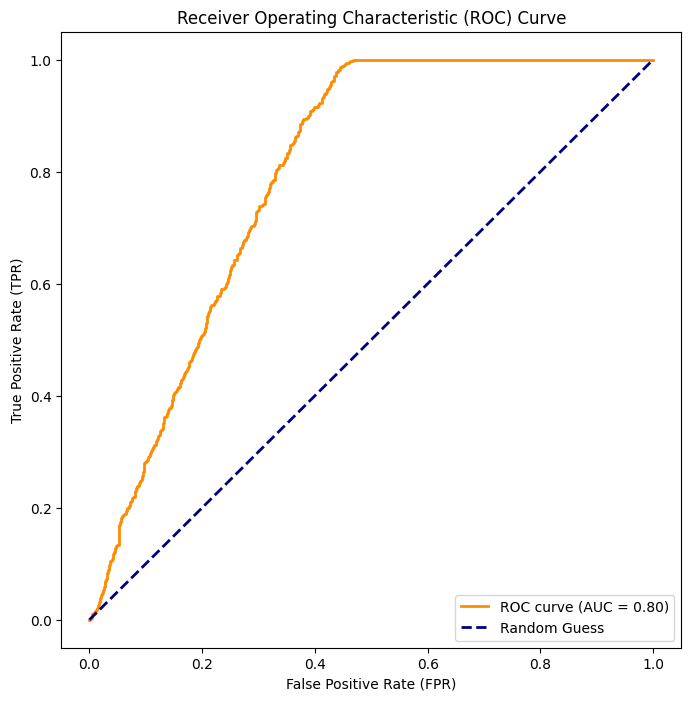

In [186]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [187]:
# Choose a threshold based on a desired sensitivity level
desired_sensitivity = 0.8  # Going with scenario-1 (++) and 2 (+)
chosen_threshold = thresholds[np.argmax(tpr >= desired_sensitivity)]

# Binarize predictions based on the chosen threshold
y_pred_binary = (y_pred >= chosen_threshold).astype(int)

# Evaluate the model using the chosen threshold
accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
classification_rep = classification_report(y_test, y_pred_binary)

# Display results
print(f"\n Chosen Threshold: {chosen_threshold:.2f}")
print(f"\n Accuracy: {accuracy:.2f}")
print("\n Confusion Matrix:")
print(conf_matrix)
print("\n Classification Report:")
print(classification_rep)


 Chosen Threshold: 0.30

 Accuracy: 0.71

 Confusion Matrix:
[[1176  582]
 [ 156  634]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76      1758
           1       0.52      0.80      0.63       790

    accuracy                           0.71      2548
   macro avg       0.70      0.74      0.70      2548
weighted avg       0.77      0.71      0.72      2548



### Decision tree for analytical solution

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [193]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree


In [201]:
# Create a decision tree classifier with max_depth=4
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=5, random_state=42)

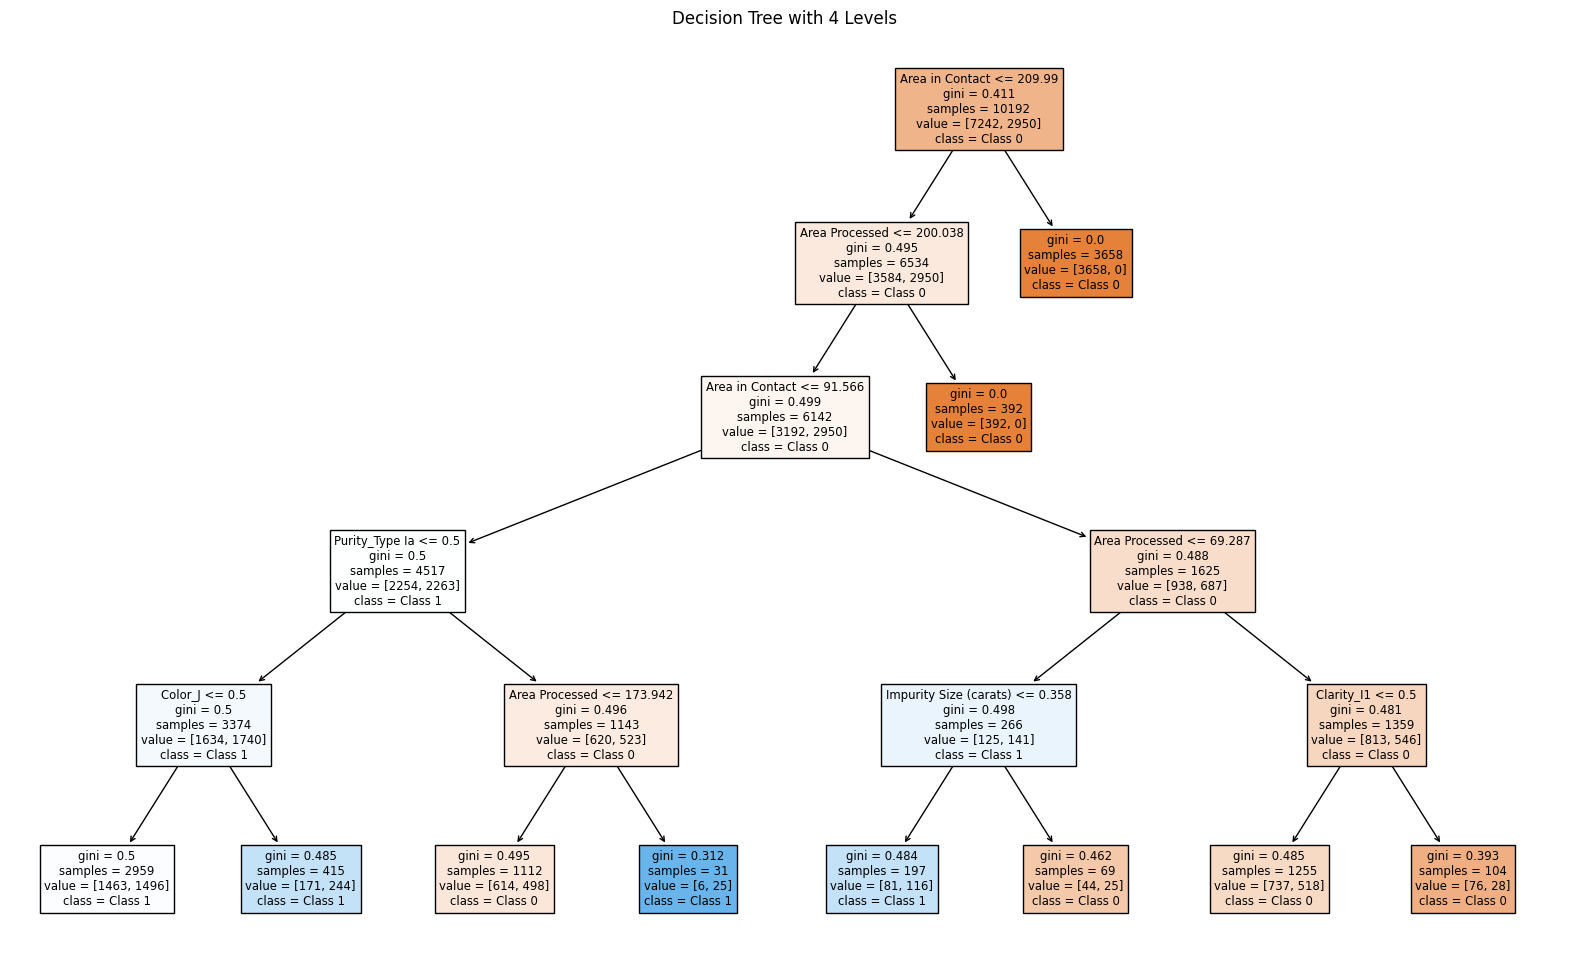

In [203]:
# Plot the decision tree
plt.figure(figsize=(20, 12))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['Class 0', 'Class 1'])
plt.title('Decision Tree with 4 Levels')
plt.show()

In [204]:
# Make predictions on the test data
predictions = clf.predict(X_test)

# Display the predicted labels
print("Predicted Labels:", predictions)

# If you have ground truth labels for the test data, you can compare predictions with actual labels
accuracy = np.mean(predictions == y_test)
print("Accuracy:", accuracy)

Predicted Labels: [1 1 1 ... 1 1 0]
Accuracy: 0.7091836734693877
